# Prediction Ensemble

In [1]:
# print_function for compatibility with Python 3
from __future__ import print_function
print('print function is ready to serve')

# Matplotlib for visualization
from matplotlib import pyplot as plt
import seaborn as sns

# display plots in the notebook
%matplotlib inline

# NumPy for numerical computing
import numpy as np
np.random.seed(123)
import random
random.seed(123)

# Pandas for DataFrames
import pandas as pd
pd.set_option('display.max_column', 100)

import os
import gc
from skimage import io
from skimage.transform import rescale, resize, downscale_local_mean

print function is ready to serve


In [2]:
import sys
sys.path.append('./utils')

from data import Data, load_test_image
from models import Models
from tags import Tags
tags = Tags()

Using TensorFlow backend.


In [3]:
PLANET_KAGGLE_ROOT = '/data/planet-data/'
if not os.path.exists(PLANET_KAGGLE_ROOT):
    PLANET_KAGGLE_ROOT = '/Users/jiayou/Documents/Kaggle Data/Amazon'

N_TAGS = 17
N_TRAIN = 40479
# N_TRAIN = 10
N_TEST_T = 40669
N_TEST_F = 20522
N_TEST = N_TEST_T + N_TEST_F

In [4]:
thres = [0.23067564, 0.27402788, 0.15499838, 0.18645976, 0.12418672, 0.093219191, 0.14909597, 0.13256209, 0.041971382, 0.17731731, 0.10376091, 0.25468382, 0.090709485, 0.13336645, 0.13344041, 0.10004906, 0.036582272]
# thres = [0.2]*17
for i in range(N_TAGS):
    thres[i] = (thres[i] + 0.2)/2
#     if thres[i] > 0.2:
# #         thres[i] = 0.21
#     else:
#         thres[i] = 0.19

thres = [ 0.205 ,  0.2345,  0.206 ,  0.203 ,  0.189 ,  0.1545,  0.1935,
        0.22  ,  0.222 ,  0.143 ,  0.1335,  0.1775,  0.1845,  0.169 ,
        0.191 ,  0.149 ,  0.1615]

In [5]:
def avgens():
    pred_sum = np.zeros((N_TEST, N_TAGS))
    for n in range(8):
        pred_sum += np.load(os.path.join(PLANET_KAGGLE_ROOT, 'ensemble', 'raw_pred.v13-n{}-tune.npy'.format(n)))
    pred_sum /= 8
    return pred_sum

thres = [0.2]*17
pred_sum = avgens()
result = tags.pred_to_output(pred_sum, thres)
result.to_csv('submission.v13-tune-1weather-2.avgens.csv', index = None)

In [45]:
pred_sum = avgens()
pred_tag = (pred_sum > 0.2).astype('int')
pred_tag[:5]

array([[0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0]])

In [51]:
def make_cooccurence_matrix(idx):
    select_tag = pred_tag[:,idx]
    c_matrix = select_tag.T.dot(select_tag)
    sns.heatmap(c_matrix)
    return c_matrix

array([[ 5820,  2435,   808,   491],
       [ 2435, 45248,   485,  1610],
       [  808,   485,  4095,   448],
       [  491,  1610,   448, 12231]])

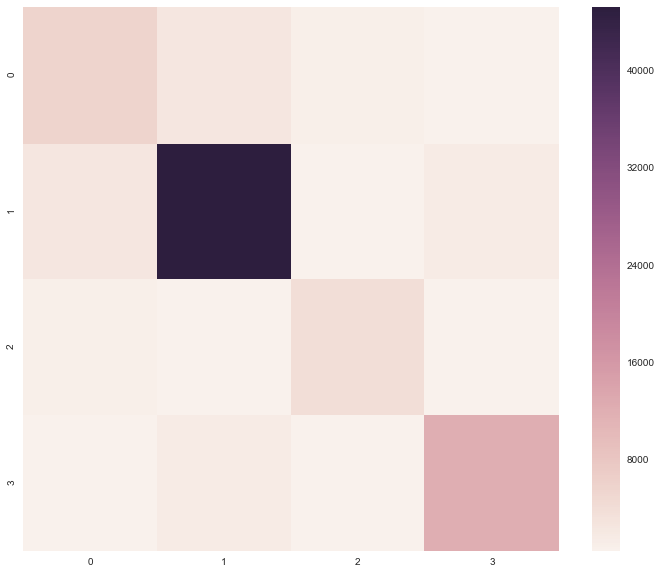

In [52]:
plt.figure(figsize = (12, 10))
make_cooccurence_matrix([0,3,9,10])
haze, clear, cloudy, partly-cloudy

array([ 4,  6,  9, 18, 34])

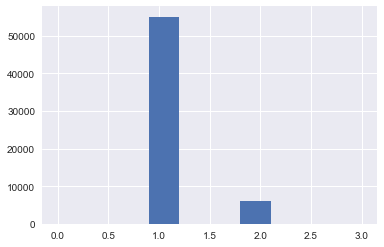

In [102]:
condition = np.array([0 for i in range(N_TEST)])
for i in [0,3,9,10]:
    condition += pred_tag[:,i]
plt.hist(condition)
mask = np.logical_or(condition == 2, condition == 3)
mask_idx = np.where(mask)[0]
mask_idx[:5]

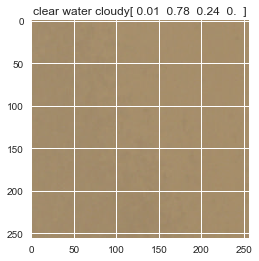

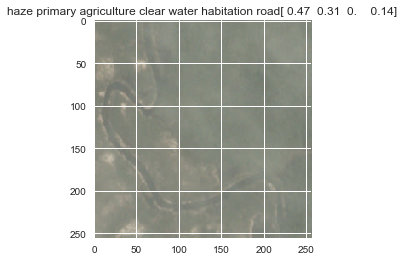

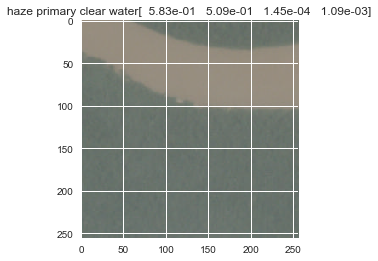

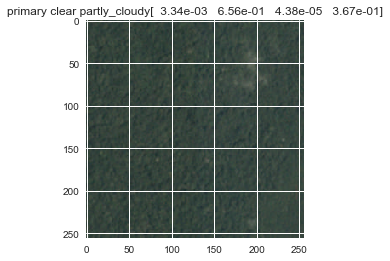

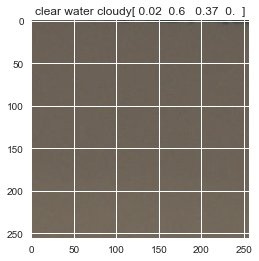

In [110]:
pred = pred_sum
weather = pred[:,[0,3,9,10]]
for i in range(5):
    index = random.randint(0, len(mask_idx))
    plt.figure()
    plt.imshow(load_test_image(mask_idx[index]))
    plt.title(tags.pred_to_tags(pred[mask_idx[index]]) + np.array_str(weather[mask_idx[index]], precision = 2))

# haze, clear, cloudy, partly-cloudy

In [5]:
def pred_to_tags_2(y, thres=[0.2]*N_TAGS):
        weather_labels = [0, 3, 9, 10]
        maxw = 0
        w = 3
        tag_list = []
        for i in range(N_TAGS):
            tag = tags.tag_idx[i]
            if i in weather_labels:
                if y[i] > maxw:
                    maxw = y[i]
                    w = i
            else:
                if y[i] >= thres[i]:
                    tag_list.append(tag)
        if maxw >= 0.5:
            tag_list.append(tags.tag_idx[w])
        else:
            for i in weather_labels:
                if y[i] >= thres[i]:
                    tag_list.append(tags.tag_idx[i])
        return ' '.join(tag_list)

In [140]:
print(pred_to_tags_2(pred[4]))
print(pred[4,[0,3,9,10]])

primary partly_cloudy
[  4.90231356e-04   1.75845843e-03   2.26660344e-01   7.82783084e-01]


In [6]:
# thres = [0.2]*17
# pred_sum = np.zeros((N_TEST, N_TAGS))
# for n in range(8):
#     current_pred = (np.load(os.path.join(PLANET_KAGGLE_ROOT, 'ensemble', 'raw_pred.v13-n{}.npy'.format(n))) > 0.2).astype('int')
#     pred_sum += current_pred
# pred_sum = (pred_sum >= 4).astype('int')
# result = tags.pred_to_output(pred_sum, thres)
# result.to_csv('submission.v13.voteens.csv', index = None)

In [94]:
def voteens():
    vote = 32
    pred_sum = np.zeros((N_TEST, N_TAGS))
    for n in range(8):
        current_pred = np.load(os.path.join(PLANET_KAGGLE_ROOT, 'ensemble', 'raw_pred.v13-n{}-tune.tta8.npy'.format(n)))
        current_pred = (current_pred > 0.2).astype('int').reshape((N_TEST, 8, N_TAGS)).sum(axis=1)
        pred_sum += current_pred
    return pred_sum

# thres = [0.2]*17
# pred_sum = (pred_sum >= vote).astype('int')
# result = tags.pred_to_output(pred_sum, thres)
# result.to_csv('submission.v13.voteens.csv', index = None)

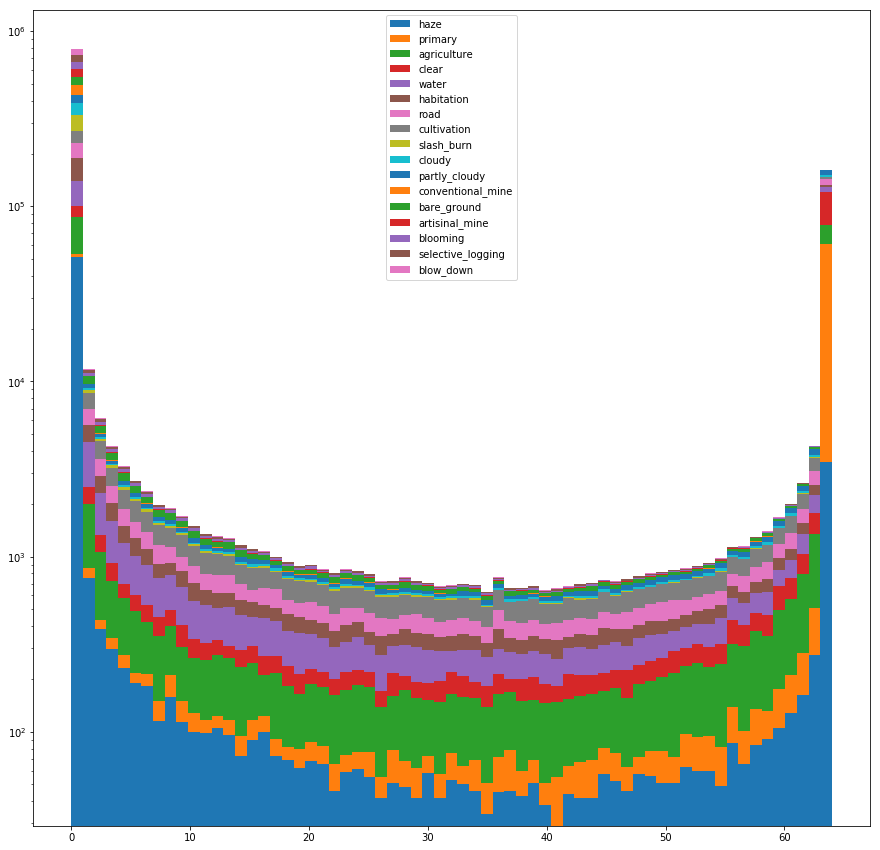

In [20]:
plt.figure(figsize=(15,15))
plt.hist(pred_sum, bins=65, label=[tags.idx_to_tag(i) for i in range(N_TAGS)], stacked=True, log=True)
plt.legend()

In [96]:
avg = avgens()
vot = voteens()

In [100]:
def diff(a, b):
    return ((a >= 0.2) != (b >= 0.2)).astype('int').sum()
for t in range(20, 40):
    print(t, diff(avg, (vot >= t).astype('int')))

20 5657
21 4794
22 4023
23 3274
24 2657
25 2134
26 1837
27 1732
28 1820
29 2125
30 2576
31 3138
32 3716
33 4344
34 4998
35 5681
36 6352
37 7046
38 7715
39 8390


39

In [98]:
aov = np.logical_or((avg >= 0.2), (vot >= 32)).astype('int')
thres = [0.2]*17
result = tags.pred_to_output(aov, thres)
result.to_csv('submission.v13-tune.aovens.csv', index = None)

# ROC on train validation data

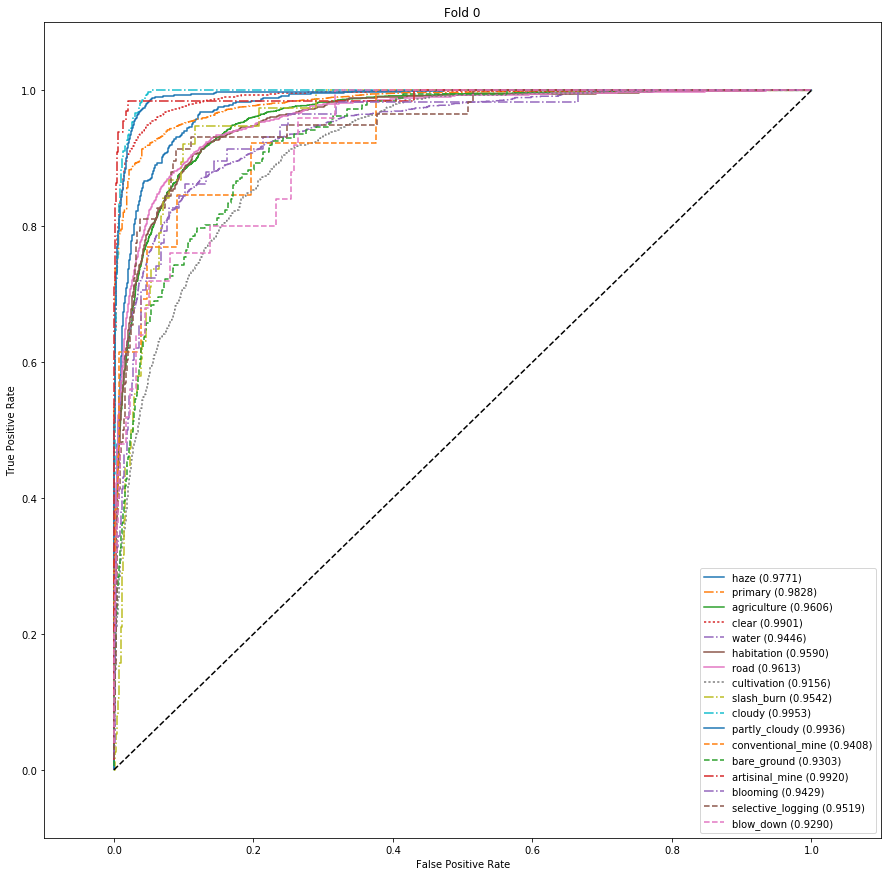

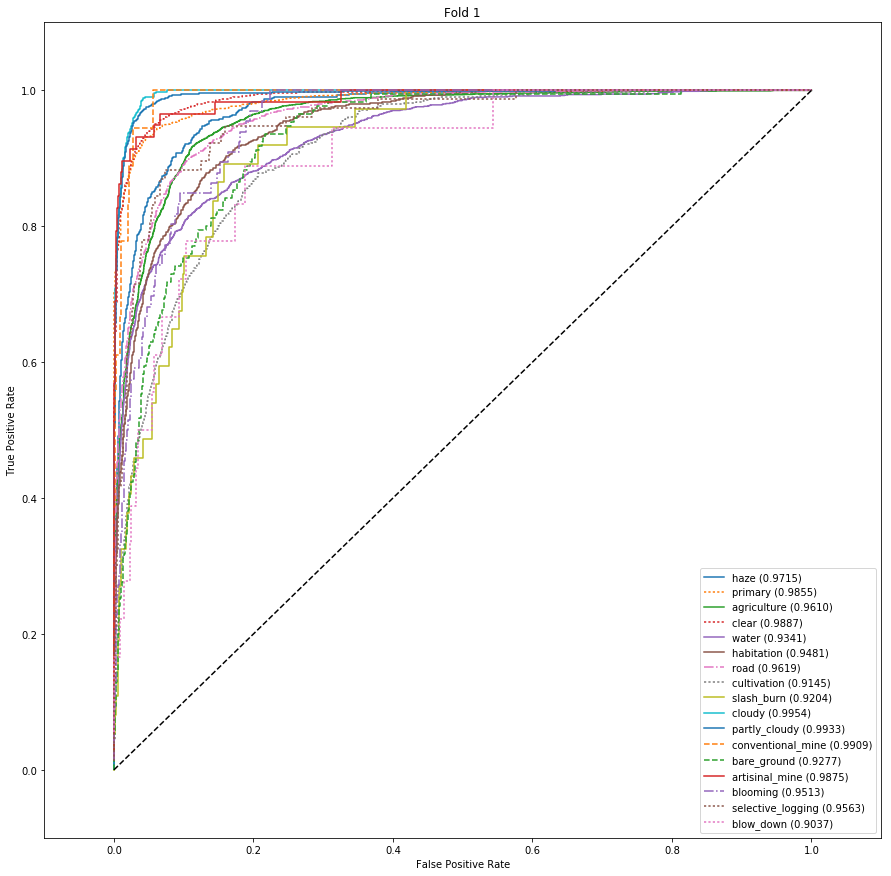

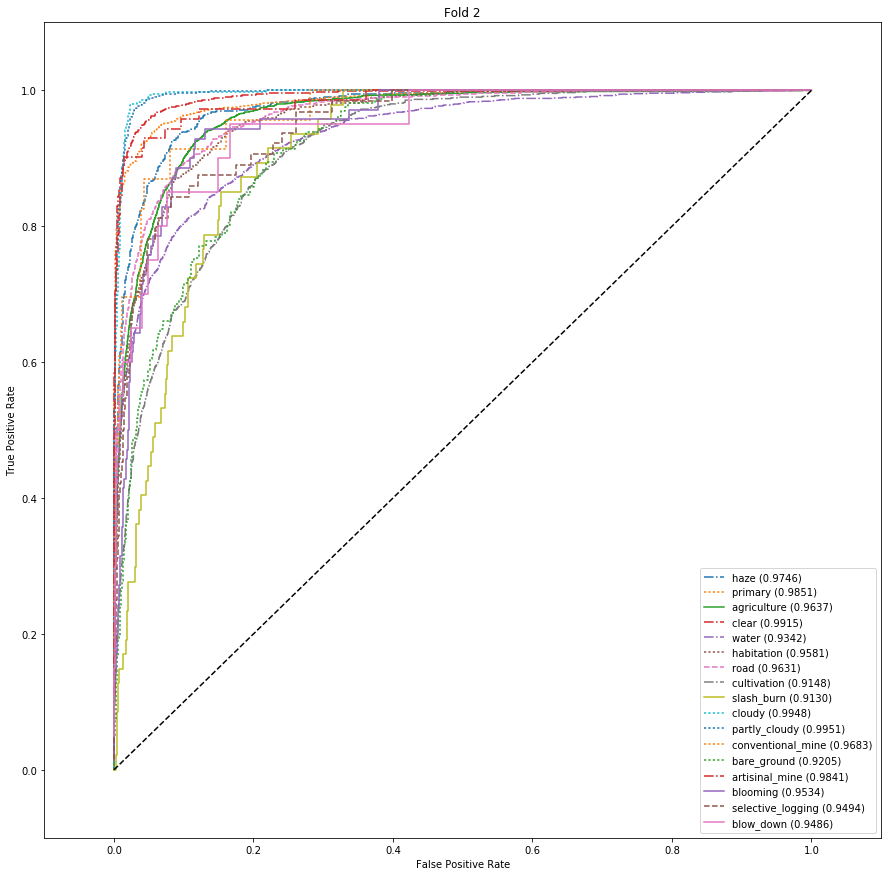

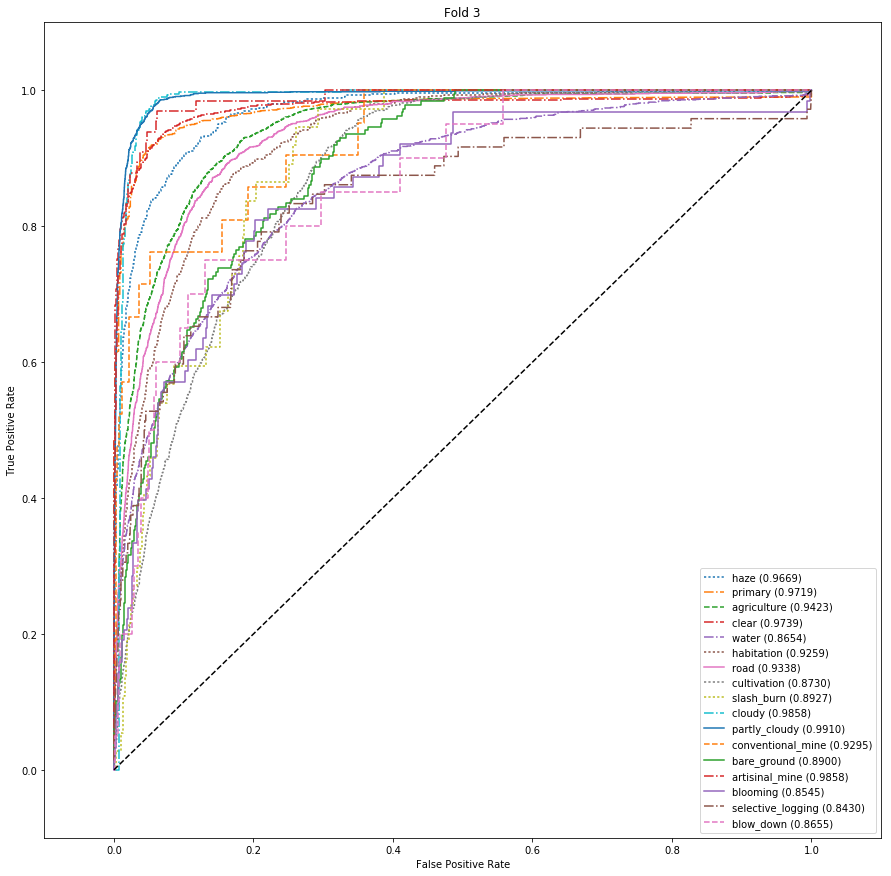

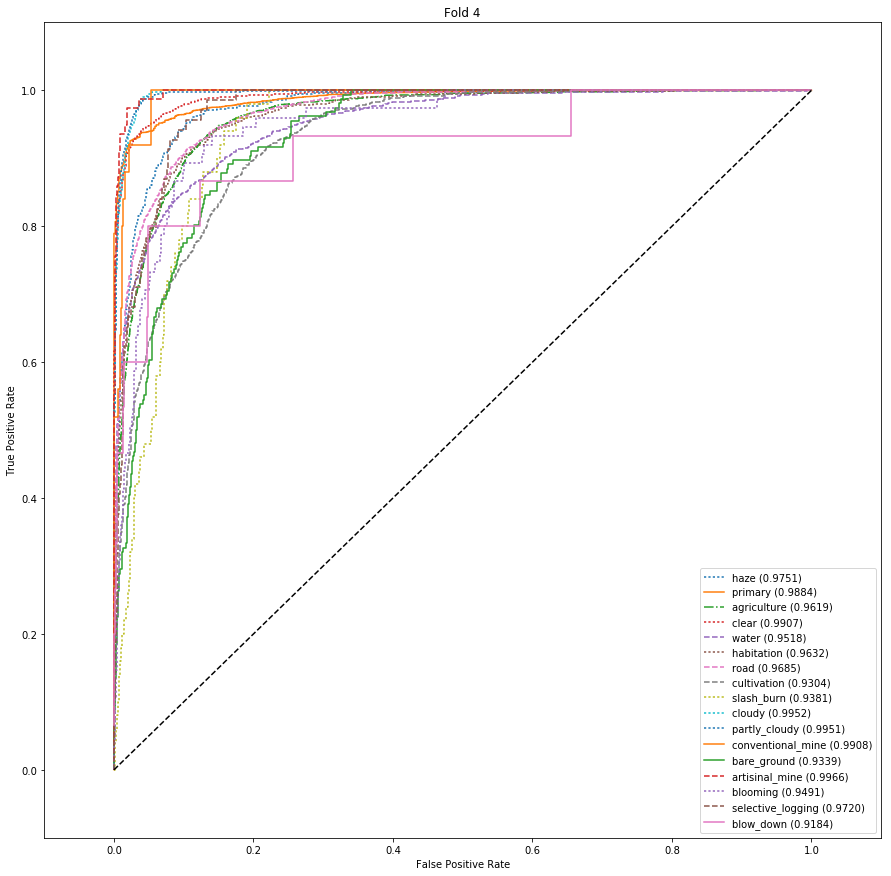

In [4]:
true = tags.y_train(range(N_TRAIN))
for n in [0,1,2,3,4]:
    pred = np.load(os.path.join(PLANET_KAGGLE_ROOT, 'ensemble', 'raw_train_pred.v9.f{}.tta.npy'.format(n)))
    v = [x for x in range(N_TRAIN) if x % 5 == n]
    tags.plot_roc(pred[v,:], true[v,:], title='Fold {}'.format(n))

In [10]:
np.array([[1,2],[3,4],[5,6],[7,8]]).reshape((2,2,2)).sum(axis=1)

array([[ 4,  6],
       [12, 14]])